In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
import torch
from scipy.special import softmax 
from sklearn.preprocessing import StandardScaler

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.infer import Predictive
from sklearn.model_selection import train_test_split
import pickle

### Data Processing

In [2]:
scaler = StandardScaler()
df = pd.read_pickle('../pickle/df.pkl')

In [3]:
df_sampled = df.sample(1400,random_state=47)

In [4]:
df_features = df_sampled.iloc[:,:-1].copy()
df_target = df_sampled.iloc[:,-1].copy()

In [5]:
df_features = scaler.fit_transform(df_features)

In [6]:
df_train_features, df_test_features,df_train_target, df_test_target =  train_test_split(df_features,df_target,stratify=df_target,random_state=47, test_size=1/7)

df_train_features, df_val_features,df_train_target, df_val_target =  train_test_split(df_train_features,df_train_target,stratify=df_train_target,random_state=47, test_size=1/6)

In [7]:
df_train_target = df_train_target.to_numpy()
df_test_target = df_test_target.to_numpy()
df_val_target = df_val_target.to_numpy()

In [8]:
D = df_train_features.shape[1]
N_train = df_train_features.shape[0]
N_test = df_test_features.shape[0]
N_val = df_val_features.shape[0]
n_cat = 11 
degF=5
tau=10

### Ancestral Sampling 

In [122]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [123]:
# sample coefficients (beta)
beta = np.random.normal(0,1,size=D)
print("beta:", beta)

beta_array = np.zeros((n_cat,D))

for i in range(n_cat):
    
    beta_array[i,:] = np.random.normal(0,1,size=D)
    
# sample observations (y's)
y = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([(np.dot(beta_array[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y[n,:] = np.random.multinomial(1, p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    #print('n, p and y ', n, p, y[n,:])

beta: [ 0.74122682  0.74561872  0.18695573  0.04654128 -0.59934611 -1.09892932
  1.05015333  0.95079291  0.66529246 -0.03065803 -0.29963162 -0.27708144
  0.96487826 -0.96600051]


In [124]:
label_array = np.array([]) 
for i in y:
    label_array = np.append(label_array,np.argmax(i))


In [125]:
from collections import Counter

counts = Counter(label_array)
counts

Counter({1.0: 72,
         0.0: 77,
         8.0: 126,
         3.0: 52,
         10.0: 116,
         9.0: 58,
         6.0: 95,
         5.0: 81,
         7.0: 83,
         4.0: 46,
         2.0: 50})

In [126]:
print("Accuracy:", 1.0*np.sum(label_array == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.1308411214953271


### Model implementation with Pyro

In [127]:
def model(X, n_cat, degF, tau, obs=None):
    
    input_dim = X.shape[1]
    
    
    mu_beta = pyro.sample("mu_beta", dist.StudentT(df=torch.ones(n_cat)*degF, 
                                                   loc=torch.zeros(n_cat), 
                                                   scale=torch.ones(n_cat)).to_event()) # Prior for the bias mean      
    sigma_beta  = pyro.sample("sigma_beta",  dist.HalfCauchy(tau*torch.ones(n_cat)).to_event()) # Prior for the bias standard deviation
    
    beta  = pyro.sample("beta", dist.Normal(mu_beta*torch.ones(n_cat), 
                                            sigma_beta*torch.ones(input_dim, n_cat)).to_event()) # Priors for the regression coefficents

    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), 
                                             5.*torch.ones(1, n_cat)).to_event())  # Prior for the bias/intercept
    
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

In [128]:
X_train = torch.tensor(df_train_features).float()
y_train = torch.tensor(df_train_target.flatten()).float()

#### Parameter Tuning

##### Degree of Freedom

In [129]:
degF_range = [4,5,6]

acc_val_degF = []


for degF in degF_range:
    

      # Define guide function
    guide = AutoMultivariateNormal(model)

    # Reset parameter values
    pyro.clear_param_store()

    # Define the number of optimization steps
    n_steps = 10000

    # Setup the optimizer
    adam_params = {"lr": 0.001}
    optimizer = ClippedAdam(adam_params)

    # Setup the inference algorithm
    elbo = Trace_ELBO(num_particles=1)
    svi = SVI(model, guide, optimizer, loss=elbo)

    # Do gradient steps
    for step in range(n_steps):
        elbo = svi.step(X_train, n_cat, degF, tau, y_train)
        if step % 1000 == 0:
            print("[%d] ELBO: %.1f" % (step, elbo))
            
            
    

    predictive = Predictive(model, guide=guide, num_samples=2000,
                            return_sites=("alpha", "beta"))
    samples = predictive(X_train, n_cat, degF, tau, y_train)
    
    samples_alpha = samples["alpha"].detach().squeeze()
    samples_beta = samples["beta"].detach().squeeze()
    
    mean_betas = samples_beta.mean(axis=0)
    mean_betas = mean_betas.T
    mean_alpha = samples_alpha.mean(axis=0)
    mean_alpha = mean_alpha.T
    
    
    y_val_pred = np.zeros((N_val,n_cat))
    
    for n in range(N_val):

        probs = np.zeros(n_cat)
        for i in range(n_cat):
            probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_val_features[n,:]))])

        p =  softmax(probs)
        y_val_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
        
    y_val_pred = y_val_pred[:,0]
    
    acc = 1.0*np.sum(y_val_pred == df_val_target.flatten()) / len(df_val_target)
    
    print({degF:acc})
    acc_val_degF.append({degF:acc})
   

[0] ELBO: 13725.1
[1000] ELBO: 9291.9
[2000] ELBO: 6170.1
[3000] ELBO: 4231.5
[4000] ELBO: 2748.7
[5000] ELBO: 1983.1
[6000] ELBO: 1673.8
[7000] ELBO: 1604.3
[8000] ELBO: 1572.5
[9000] ELBO: 1571.1
{4: 0.48255813953488375}
[0] ELBO: 19804.8
[1000] ELBO: 14301.2
[2000] ELBO: 10249.6
[3000] ELBO: 7098.6
[4000] ELBO: 4761.2
[5000] ELBO: 3424.5
[6000] ELBO: 2673.1
[7000] ELBO: 2082.6
[8000] ELBO: 1808.6
[9000] ELBO: 1688.2
{5: 0.45348837209302323}
[0] ELBO: 19843.9
[1000] ELBO: 12672.7
[2000] ELBO: 8069.8
[3000] ELBO: 5084.0
[4000] ELBO: 3171.0
[5000] ELBO: 2302.4
[6000] ELBO: 1943.8
[7000] ELBO: 1732.9
[8000] ELBO: 1646.1
[9000] ELBO: 1619.8
{6: 0.45348837209302323}


In [130]:
acc_val_degF

[{4: 0.48255813953488375}, {5: 0.45348837209302323}, {6: 0.45348837209302323}]

##### Tau in Variance

In [131]:
tau_range = [1,10,50,100]
degF = 4

acc_val_tau = []


for tau in tau_range:
    

      # Define guide function
    guide = AutoMultivariateNormal(model)

    # Reset parameter values
    pyro.clear_param_store()

    # Define the number of optimization steps
    n_steps = 10000

    # Setup the optimizer
    adam_params = {"lr": 0.001}
    optimizer = ClippedAdam(adam_params)

    # Setup the inference algorithm
    elbo = Trace_ELBO(num_particles=1)
    svi = SVI(model, guide, optimizer, loss=elbo)

    # Do gradient steps
    for step in range(n_steps):
        elbo = svi.step(X_train, n_cat, degF, tau, y_train)
        if step % 1000 == 0:
            print("[%d] ELBO: %.1f" % (step, elbo))
            
            
    

    predictive = Predictive(model, guide=guide, num_samples=2000,
                            return_sites=("alpha", "beta"))
    samples = predictive(X_train, n_cat, degF, tau, y_train)
    
    
    samples_alpha = samples["alpha"].detach().squeeze()
    samples_beta = samples["beta"].detach().squeeze()
    
    
    mean_betas = samples_beta.mean(axis=0)
    mean_betas = mean_betas.T
    mean_alpha = samples_alpha.mean(axis=0)
    mean_alpha = mean_alpha.T
    
    
    y_val_pred = np.zeros((N_val,n_cat))
    
    for n in range(N_val):

        probs = np.zeros(n_cat)
        for i in range(n_cat):
            probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_val_features[n,:]))])

        p =  softmax(probs)
        y_val_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
        
    y_val_pred = y_val_pred[:,0]
    
    acc = 1.0*np.sum(y_val_pred == df_val_target.flatten()) / len(df_val_target)
    print({tau:acc})
    acc_val_tau.append({tau:acc})
   

[0] ELBO: 3794.4
[1000] ELBO: 1648.7
[2000] ELBO: 1472.4
[3000] ELBO: 1445.5
[4000] ELBO: 1430.1
[5000] ELBO: 1426.6
[6000] ELBO: 1434.6
[7000] ELBO: 1412.1
[8000] ELBO: 1411.1
[9000] ELBO: 1412.2
{1: 0.47093023255813954}
[0] ELBO: 21113.8
[1000] ELBO: 14998.2
[2000] ELBO: 10222.1
[3000] ELBO: 7280.9
[4000] ELBO: 5026.9
[5000] ELBO: 3545.8
[6000] ELBO: 2636.0
[7000] ELBO: 2262.1
[8000] ELBO: 1918.9
[9000] ELBO: 1797.1
{10: 0.45348837209302323}
[0] ELBO: 90624.5
[1000] ELBO: 83328.2
[2000] ELBO: 77410.7
[3000] ELBO: 71464.0
[4000] ELBO: 65459.3
[5000] ELBO: 59309.4
[6000] ELBO: 53703.9
[7000] ELBO: 50141.0
[8000] ELBO: 45547.6
[9000] ELBO: 40555.8
{50: 0.1744186046511628}
[0] ELBO: 228061.2
[1000] ELBO: 221429.5
[2000] ELBO: 215634.4
[3000] ELBO: 207805.8
[4000] ELBO: 202420.7
[5000] ELBO: 195069.0
[6000] ELBO: 190540.0
[7000] ELBO: 184530.9
[8000] ELBO: 178921.2
[9000] ELBO: 174405.1
{100: 0.1511627906976744}


In [132]:
acc_val_tau

[{1: 0.47093023255813954},
 {10: 0.45348837209302323},
 {50: 0.1744186046511628},
 {100: 0.1511627906976744}]

### Model implementation with Pyro V2

In [133]:
def model_2(X, n_cat,lambda_, tau, obs=None):
    
    input_dim = X.shape[1]
    
    
    mu_beta = pyro.sample("mu_beta", dist.Normal(torch.zeros(n_cat), 
                                            lambda_*torch.ones(n_cat)).to_event()) # Prior for the bias mean  
    
    sigma_beta  = pyro.sample("sigma_beta",  dist.HalfCauchy(tau*torch.ones(n_cat)).to_event()) # Prior for the bias standard deviation
    
    beta  = pyro.sample("beta", dist.Normal(mu_beta*torch.ones(n_cat), 
                                            sigma_beta*torch.ones(input_dim, n_cat)).to_event()) # Priors for the regression coefficents

    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), 
                                             5.*torch.ones(1, n_cat)).to_event())  # Prior for the bias/intercept
    
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

##### lambda

In [134]:
lambda_range = [1,5,10]

acc_val_lambda = []


for lambda_ in lambda_range:
    

      # Define guide function
    guide = AutoMultivariateNormal(model_2)

    # Reset parameter values
    pyro.clear_param_store()

    # Define the number of optimization steps
    n_steps = 10000

    # Setup the optimizer
    adam_params = {"lr": 0.001}
    optimizer = ClippedAdam(adam_params)

    # Setup the inference algorithm
    elbo = Trace_ELBO(num_particles=1)
    svi = SVI(model_2, guide, optimizer, loss=elbo)

    # Do gradient steps
    for step in range(n_steps):
        elbo = svi.step(X_train, n_cat, lambda_, tau, y_train)
        if step % 1000 == 0:
            print("[%d] ELBO: %.1f" % (step, elbo))
            
            
    

    predictive = Predictive(model_2, guide=guide, num_samples=2000,
                            return_sites=("alpha", "beta"))
    samples = predictive(X_train, n_cat, lambda_, tau, y_train)
    
    
    samples_alpha = samples["alpha"].detach().squeeze()
    samples_beta = samples["beta"].detach().squeeze()
    
    
    mean_betas = samples_beta.mean(axis=0)
    mean_betas = mean_betas.T
    mean_alpha = samples_alpha.mean(axis=0)
    mean_alpha = mean_alpha.T
    
    
    y_val_pred = np.zeros((N_val,n_cat))
    
    for n in range(N_val):

        probs = np.zeros(n_cat)
        for i in range(n_cat):
            probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_val_features[n,:]))])

        p =  softmax(probs)
        y_val_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
        
    y_val_pred = y_val_pred[:,0]
    
    acc = 1.0*np.sum(y_val_pred == df_val_target.flatten()) / len(df_val_target)
    print({lambda_:acc})
    acc_val_lambda.append({lambda_:acc})
   

[0] ELBO: 188394.6
[1000] ELBO: 181739.8
[2000] ELBO: 175997.5
[3000] ELBO: 169426.1
[4000] ELBO: 163851.9
[5000] ELBO: 156041.9
[6000] ELBO: 151657.8
[7000] ELBO: 143846.9
[8000] ELBO: 140607.7
[9000] ELBO: 135169.0
{1: 0.12790697674418605}
[0] ELBO: 151886.7
[1000] ELBO: 145876.4
[2000] ELBO: 138873.1
[3000] ELBO: 133593.0
[4000] ELBO: 128108.8
[5000] ELBO: 122448.1
[6000] ELBO: 117237.1
[7000] ELBO: 111032.7
[8000] ELBO: 105989.5
[9000] ELBO: 101011.6
{5: 0.21511627906976744}
[0] ELBO: 212563.6
[1000] ELBO: 205555.6
[2000] ELBO: 198486.4
[3000] ELBO: 191662.0
[4000] ELBO: 184790.4
[5000] ELBO: 177831.9
[6000] ELBO: 171635.6
[7000] ELBO: 164842.4
[8000] ELBO: 158353.0
[9000] ELBO: 152697.5
{10: 0.0755813953488372}


#### Final Model training 

In [135]:
degF=4
tau=1

In [136]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, n_cat, degF, tau, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 5061.9
[1000] ELBO: 1924.2
[2000] ELBO: 1550.4
[3000] ELBO: 1482.2
[4000] ELBO: 1434.3
[5000] ELBO: 1431.9
[6000] ELBO: 1420.3
[7000] ELBO: 1416.6
[8000] ELBO: 1406.6
[9000] ELBO: 1417.3


In [137]:
predictive = Predictive(model, guide=guide, num_samples=10000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, n_cat, degF, tau, y_train)

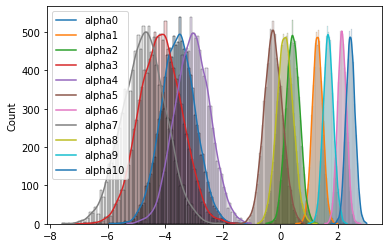

In [138]:
samples_alpha = samples["alpha"].detach().squeeze()
for c in range(n_cat):
    sns.histplot(samples_alpha[:,c], kde=True, alpha=0.2)
plt.legend(["alpha%d" % c for c in range(n_cat)])
plt.show()

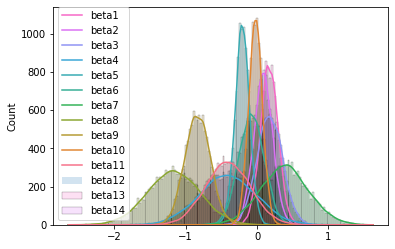

In [139]:
samples_beta = samples["beta"].detach().squeeze()
for c in range(1):
    sns.histplot(samples_beta[:,c], kde=True, alpha=0.2)
plt.legend(["beta%d" % int(int(c)+1) for c in range(D)])
plt.show()

In [141]:
mean_betas = samples_beta.mean(axis=0)
mean_betas = mean_betas.T

mean_alpha = samples_alpha.mean(axis=0)
mean_alpha = mean_alpha.T

In [149]:
with open('./mean_betas.pkl','wb') as f:
    pickle.dump(mean_betas,f)
    
with open('./mean_alpha.pkl','wb') as f:
    pickle.dump(mean_alpha,f)

### Inference and computation of accuracy on the train dataset 

In [142]:
# sample observations (y's)
y_train_pred = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y_train_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli


In [143]:
y_train_pred = y_train_pred[:,0]

In [144]:
print("Accuracy:", 1.0*np.sum(y_train_pred == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.4976635514018692


### Inference and computation of accuracy on the test dataset 

In [145]:
# sample observations (y's)
y_test_pred = np.zeros((N_test,n_cat))
for n in range(N_test):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_test_features[n,:]))])
        
    p =  softmax(probs)
    y_test_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli


In [146]:
y_test_pred = y_test_pred[:,0]

In [147]:
print("Accuracy:", 1.0*np.sum(y_test_pred == df_test_target.flatten()) / len(df_test_target))

Accuracy: 0.46511627906976744



DOUBLE CHECK

* fillna using KNN inputer 
* is averaging the betas giving the best result for the predictions 
* is ancentral sampling correct? 
* Consider different distributions for priors

Done

* Have priors for mean and variance for betas and alphas - parameter tuning 
* Train model on more data - currently 100 

TODO

* Feature engineer name and album name and retrain logistic regression model using these attributes
* Hyper parameter tuning
* Extend it with FFNN 
* Train model on more data (like 10000)